# Progetto di Data and Web mining

Matteo Spanio, A.A. 2021/2022

# Predizione sulla media

Alla luce dell'indagine condotta sui dati cerchiamo di stabilire un punto di riferimento su cui basare le predizioni dei vari modelli.

## Media generale

In particolare, si vede che la distribuzione dei `logerror` è fortemente centrata sulla media, si può allora pensare di utilizzare la media come predittore.

In [27]:
import Zillow.data as zd
from Zillow.transform import ZillowTransformer

# we don't use splitted train and validation sets since we don't have to tune the mean
df_train = zd.get_train_and_validation_dataset()
df_test = zd.get_test_dataset()

preprocessor = ZillowTransformer()
preprocessor.fit(df_train)

df_train = preprocessor.transform(df_train)
df_test = preprocessor.transform(df_test)

In [36]:
from Zillow.models import BaseModel
from Zillow.metrics import print_measure

X, y = zd.split_x_y(df_train)
X_test, y_test = zd.split_x_y(df_test)

model = BaseModel()

model.fit(X, y)

print_measure(y_true=y_test, y_pred=model.predict(X_test))

Mean absolute error: 0.06998
 Mean squared error: 0.02862
           R2 score: -0.00010


## Media per contea

Da un'ulteriore analisi si nota però c'è una notevole differenza nella varianza del logerror tra contee

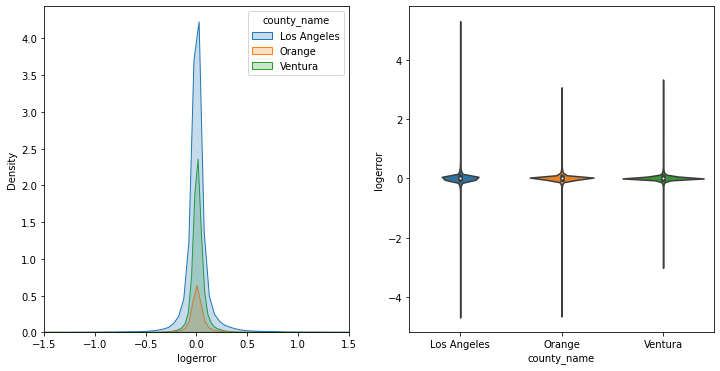

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))

sns.kdeplot(data=df_train, x='logerror', hue='county_name', fill=True, ax=ax1)
ax1.set_xlim(-1.5, 1.5)
sns.violinplot(x='county_name', y='logerror', data=df_train, ax=ax2);

A questo punto vediamo se la media delle previsioni per media di ogni contea migliora il risultato ottenuto

In [30]:
from Zillow.types import Features as ft, MoreFeatures as mft

df_orange = df_train[df_train[mft.county_name.value] == 'Orange']
df_orange_test = df_test[df_test[mft.county_name.value] == 'Orange']
df_ventura = df_train[df_train[mft.county_name.value] == 'Ventura']
df_ventura_test = df_test[df_test[mft.county_name.value] == 'Orange']
df_la = df_train[df_train[mft.county_name.value] == 'Los Angeles']
df_la_test = df_test[df_test[mft.county_name.value] == 'Orange']

county_mae = []
county_mse = []
county_r2 = []

In [31]:
from Zillow.metrics import measure_model
X, y = zd.split_x_y(df_orange)
X_test, y_test = zd.split_x_y(df_orange_test)

model = BaseModel()

model.fit(X, y)

print('Orange logerror mean')
print_measure(y_true=y_test, y_pred=model.predict(X_test))
score = measure_model(y_true=y_test, y_pred=model.predict(X_test))
county_mae.append(score[0])
county_mse.append(score[1])
county_r2.append(score[2])

Orange logerror mean
Mean absolute error: 0.06241
 Mean squared error: 0.02410
           R2 score: -0.00110


In [32]:
X, y = zd.split_x_y(df_ventura)
X_test, y_test = zd.split_x_y(df_ventura_test)

model = BaseModel()

model.fit(X, y)

print('Ventura logerror mean')
print_measure(y_true=y_test, y_pred=model.predict(X_test))
score = measure_model(y_true=y_test, y_pred=model.predict(X_test))
county_mae.append(score[0])
county_mse.append(score[1])
county_r2.append(score[2])

Ventura logerror mean
Mean absolute error: 0.06232
 Mean squared error: 0.02410
           R2 score: -0.00136


In [33]:
X, y = zd.split_x_y(df_la)
X_test, y_test = zd.split_x_y(df_la_test)

model = BaseModel()

model.fit(X, y)

print('LA logerror mean')
print_measure(y_true=y_test, y_pred=model.predict(X_test))
score = measure_model(y_true=y_test, y_pred=model.predict(X_test))
county_mae.append(score[0])
county_mse.append(score[1])
county_r2.append(score[2])

LA logerror mean
Mean absolute error: 0.06205
 Mean squared error: 0.02413
           R2 score: -0.00267


In [34]:
import numpy as np
print(f'overall mean by county:')
print(f'mae: {np.mean(county_mae):.5f}')
print(f'mse: {np.mean(county_mse):.5f}')
print(f' r2: {np.mean(county_r2):.5f}')

overall mean by county:
mae: 0.06226
mse: 0.02411
 r2: -0.00171


La media delle previsioni per contea basata sulla media è migliore rispetto a quella generale.

## Intorno al concetto di vicinanza: KNN

Partendo dall'idea che la vicinanza geografica e la similarità del tipo di costruzione abbia un forte peso sulla predizione ha senso provare a basare le proprie stime su un algoritmo fortemente basato sulla distanza: il knn

In [39]:
import pandas as pd
import Zillow.data as zd
import warnings
warnings.filterwarnings("ignore")

train, validation, test = zd.get_preprocessed_data()

X_train, y_train = zd.split_x_y(train)
X_validation, y_validation = zd.split_x_y(validation)

Per evitare che certe feature abbiano un peso molto maggiore rispetto ad altre per via di differenti scale di valori, prima di elaborare i dati li riscaliamo

In [10]:
%%time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

scaler = MinMaxScaler()

scaler.fit(X_train)

knn = KNeighborsRegressor()

params = {
    'weights': ['distance', 'uniform'],
    'n_neighbors': [x for x in range(10, 501, 10)]
}

gscv = GridSearchCV(estimator=knn,
                    return_train_score=True,
                    scoring='neg_mean_absolute_error',
                    param_grid=params,
                    cv=5,
                    verbose=1,
                    n_jobs=-1)

gscv.fit(scaler.transform( X_train ), y_train)
gscv.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 1.64 s, sys: 507 ms, total: 2.15 s
Wall time: 1h 9min 52s


{'n_neighbors': 500, 'weights': 'uniform'}

In [12]:
from Zillow.metrics import print_measure
print_measure(y_true=y_validation, y_pred=gscv.predict(scaler.transform( X_validation )))

Mean absolute error: 0.07132
 Mean squared error: 0.03006
           R2 score: 0.00005


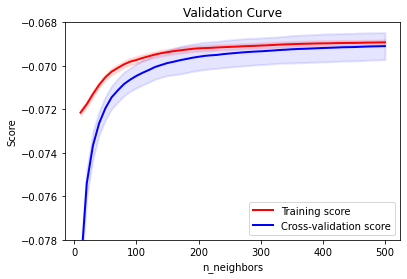

In [15]:
import Zillow.visualization as zv

zv.plot_grid_search_validation_curve(gscv, 'n_neighbors', ylim=(-.078,-.068))

In [41]:
train, validation, test = zd.get_preprocessed_data()
train = pd.concat([train, validation], axis=0, ignore_index=True)

X_train, y_train = zd.split_x_y(train)
X_test, y_test = zd.split_x_y(test)

scaler.fit(X_train)

knn = KNeighborsRegressor(n_neighbors=500, n_jobs=-1)
knn.fit(scaler.transform(X_train), y_train)

y_pred = knn.predict(scaler.transform(X_test))
print_measure(y_true=y_test, y_pred=y_pred)

Mean absolute error: 0.07026
 Mean squared error: 0.02858
           R2 score: 0.00128


Seppure mean squared error e $R^2$ siano minori in questo modello rispetto alla media, il mean absolute error viene predetto meglio dalla media.

Probabilmente verificare il knn per contea darebbe risultati migliori, ma avrebbe anche poco senso perchè già ci stiamo basando sulla vicinanza tra le X nel caso di quest'ultimo modello.